# 1) Task-1

## (a) Derive the restricted Boltzmann machine algorithm that you will implement, and explain your derivation.

Restricted Boltzmann Machine is an undirected, energy based graphical model. Visible Layer -> $v$, Hidden Layer -> $h$. 

Energy function -> $\displaystyle E( v,\ h)$:

\begin{equation*}
E( v,\ h) \ =\ -b^{T} v-c^{T} h-v^{T} Wh
\end{equation*}
here $b$ is the $k$ nodes of the visible layer; $c$ is the $j$ nodes of the hidden layer. 
$b$ and $c$ are termed bias vectors.

The energy function defines the joint probability distribution:

\begin{equation*}
p( v,\ h) \ =\ \frac{1}{z} exp\{-E( v,\ h)\}
\end{equation*}
<br>

$Z$ is the normalizing partition function ->
\begin{equation*}
Z\ =\ \sum _{v}\sum _{h} exp\{-E( v,\ h)\}
\end{equation*}
<br>
The objective is to increase $\displaystyle p( v,\ h)$ thereby decreasing the energy function.

If $x$ is only partially observable the Observed part and hidden part $h$:

\begin{equation*}
p( x) \ =\ \sum _{h}\sum _{v} p( x,\ h) \ =\ \sum _{h}\frac{e^{-E( x,\ h)}}{Z} \quad \quad \text{- eq 1}
\end{equation*}

Free Energy ->

\begin{equation}
F( x) \ =\ -\log\sum _{h} e^{-E( x,\ h)} \quad \quad \text{- eq 2}
\end{equation}

Substitute, take log and differentiate with respect to $\theta$ gives 2 phases -> negative and positive phases:

\begin{equation*}
\frac{\partial \log p( x)}{\partial \theta } \ =\ \frac{\partial F( x)}{\partial \theta } \ =\ -\sum p( x')\frac{\partial F( x')}{\partial \theta }
\end{equation*}


\begin{equation*}
E( v,\ h) \ =\ -b^{T} v-c^{T} h-v^{T} Wh\ =\ -\sum _{k} b_{k} v_{k} -\sum _{j} c_{j} h_{j} -\sum _{j}\sum _{k} W_{jk} h_{j} v_{k}
\end{equation*}



To maximize probability, first 2 terms in RHS should be as large as possible.<br>
If $b$ is negative -> $v$ = 0 and 1.<br>
If $c$ is negative -> $h$ = 0 and 1.<br>
If $W_{jk}$ is negative -> $h$ or $v$ or both $h$ and $v$ = 0.<br>
If $W_{jk}$ is positive -> $h$ or $v$ = 1.<br>
<br>
\begin{equation*}
Z\ =\ \sum _{v}\sum _{h} exp\{-E( v,\ h)\}
\end{equation*}

Gibbs sampling ->

\begin{equation*}
p( h|v) \ =\ \prod _{j} p( h_{j} |v)
\end{equation*}

\begin{equation*}
p( v|h) \ =\ \prod _{k}( v_{k} |h)
\end{equation*}

Considering binary units -> $v_k$ and $h_j\epsilon \{ 0,1 \}$.<br>
Probabilistic version of the neuron activation function is:

\begin{equation*}
P( h_{j}) \ =\ 1|v\ =\ sigm\ ( c_{j} \ +\ W_{j} v)
\end{equation*}

\begin{equation*}
P( v_{k}) \ =\ 1|h\ =\ sigm\ ( b_{k} \ +\ W'_{k} h)
\end{equation*}

Free Energy -> 

\begin{equation*}
F( v) \ =-b'v=\sum _{i}\log\left( 1+e^{c_{i} +E_{i} v}\right)
\end{equation*}

The negative phase gradient denoted by $N$ combined with the free energy equation:

\begin{equation*}
\frac{-\partial \log p( v)}{\partial W_{jk}} \ =\ E_{v}[ p( h_{x} |v) v_{j}] -v^{k}_{j} sigm\left( W_{i} v^{i} +c_{i}\right)
\end{equation*}

\begin{equation*}
\frac{-\partial \log p( v)}{\partial c_{k}} =E_{v}[ p( h_{k} |v)] -sigm\left( W_{k} v^{k}\right)
\end{equation*}

\begin{equation*}
\frac{-\partial \log p( v)}{\partial b_{j}} =E_{v}[ p( v_{j} |h)] -v^{k}_{j}
\end{equation*}

Markov chain ->

\begin{equation*}
h^{( n+1)} \sim sigm\left( W'v^{( n)} +c\right)
\end{equation*}

\begin{equation*}
v^{( n+1)} \sim sigm\left( Wh^{( n+1)} +b\right)
\end{equation*}

$h^n$ is the set of all hidden units at the n-th step of the Markov chain. Samples are obtained after only k-steps of Gibbs sampling.
<br><br>

## (b) Implement the training and inference algorithms for RBM. Train RBMs with 20, 100 and 500 hidden nodes to generate MNIST images using the training data set.

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.neural_network import BernoulliRBM

In [399]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
from torch.utils.data import DataLoader, TensorDataset

In [323]:
train_data = np.loadtxt("Dataset/mnist_train.csv", delimiter=",")
test_data = np.loadtxt("Dataset/mnist_test.csv", delimiter=",")

In [324]:
# Train test split

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(train_data)):
    x_train.append(train_data[i][1:])
    y_train.append(train_data[i][:1])
for i in range(len(test_data)):
    x_test.append(test_data[i][1:])
    y_test.append(test_data[i][:1])
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [325]:
# Implementing 0-1 Scaler

for i in range(len(x_train)):
    x_train[i] = (x_train[i] -  np.min(x_train[i], 0)) / (np.max(x_train[i], 0) - np.min(x_train[i], 0)) + 0.0001

for i in range(len(x_test)):
    x_test[i] = (x_test[i] -  np.min(x_test[i], 0)) / (np.max(x_test[i], 0) - np.min(x_test[i], 0)) + 0.0001

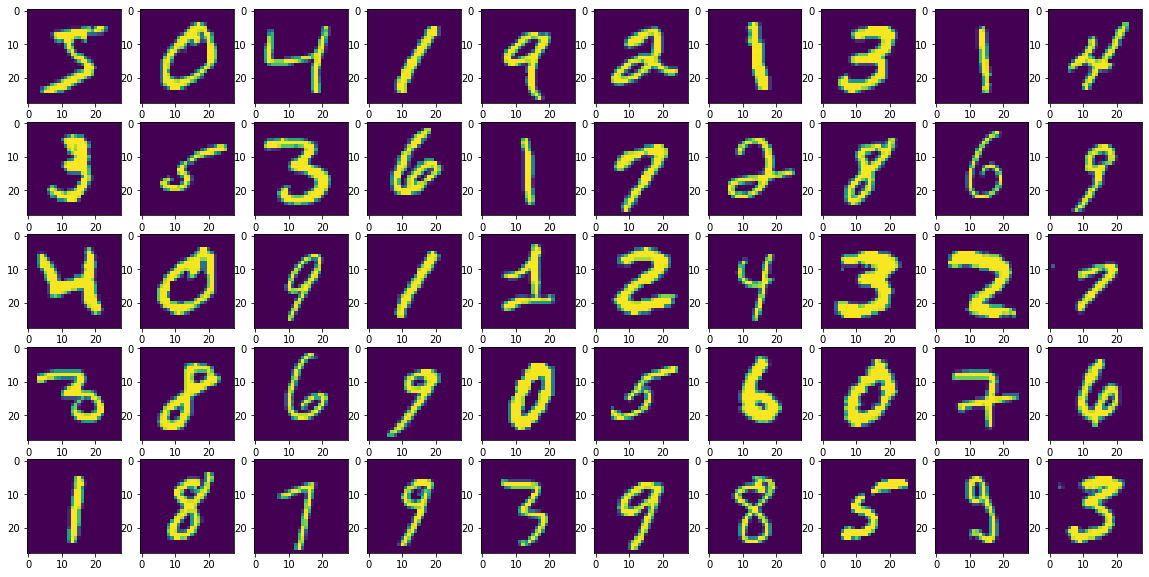

In [326]:
plt.figure(figsize=(20,10))
for i in range(0, len(x_train[:50])):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train[i].reshape((28, 28)))
plt.show()

## Without Using built in RBM Functions:

In [442]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(datasets.MNIST('Dataset', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()])), batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('Dataset', train = False, transform = transforms.Compose([transforms.ToTensor()])), batch_size = batch_size)

In [461]:
class RBM(nn.Module):
    def __init__(self, visible = 784, hidden = 500, k = 10):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden, visible) * 1e-2)
        self.v_bias = nn.Parameter(torch.zeros(visible))
        self.h_bias = nn.Parameter(torch.zeros(hidden))
        self.k = k

    def sample_from_p(self, p):
        q = torch.rand(p.size())
        sample = p - Variable(q)
        sample = F.relu(torch.sign(sample))
        
        return sample

    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
        
        return p_h, sample_h

    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
        
        return p_v, sample_v

    def forward(self, v):
        pre_h1, h1 = self.v_to_h(v)

        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)

        return v, v_

    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        free_energy = (-hidden_term - vbias_term).mean()
        
        return free_energy

# Reference: https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

In [462]:
rbm20 = RBM(hidden = 20)
rbm100 = RBM(hidden = 100)
rbm500 = RBM()

In [538]:
train_op = optim.SGD(rbm20.parameters(), 0.01)

for epoch in range(10):
    loss_ = []
    for _, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, 784))
        sample_data = data.bernoulli()
        v, v1 = rbm20(sample_data)
        loss = rbm20.free_energy(v) - rbm20.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -11.036419868469238
Training loss for 1 epoch: -10.506631851196289
Training loss for 2 epoch: -10.000022888183594
Training loss for 3 epoch: -9.74988842010498
Training loss for 4 epoch: -9.430366516113281
Training loss for 5 epoch: -9.170145034790039
Training loss for 6 epoch: -9.010117530822754
Training loss for 7 epoch: -8.651238441467285
Training loss for 8 epoch: -8.472135543823242
Training loss for 9 epoch: -8.304439544677734


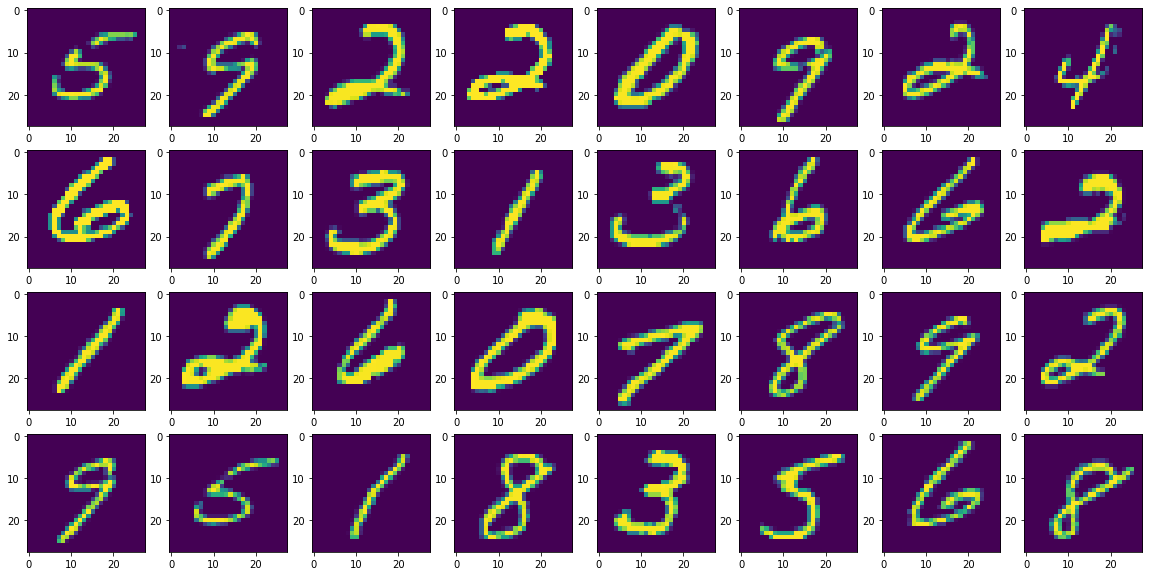

In [536]:
# Original digits

plt.figure(figsize=(20,10))
for i in range(0, len(v)):
    plt.subplot(4, 8,i+1)
    plt.imshow(np.transpose(v.view(32,1,28,28).data[i].numpy(),(1,2,0)))
plt.show()

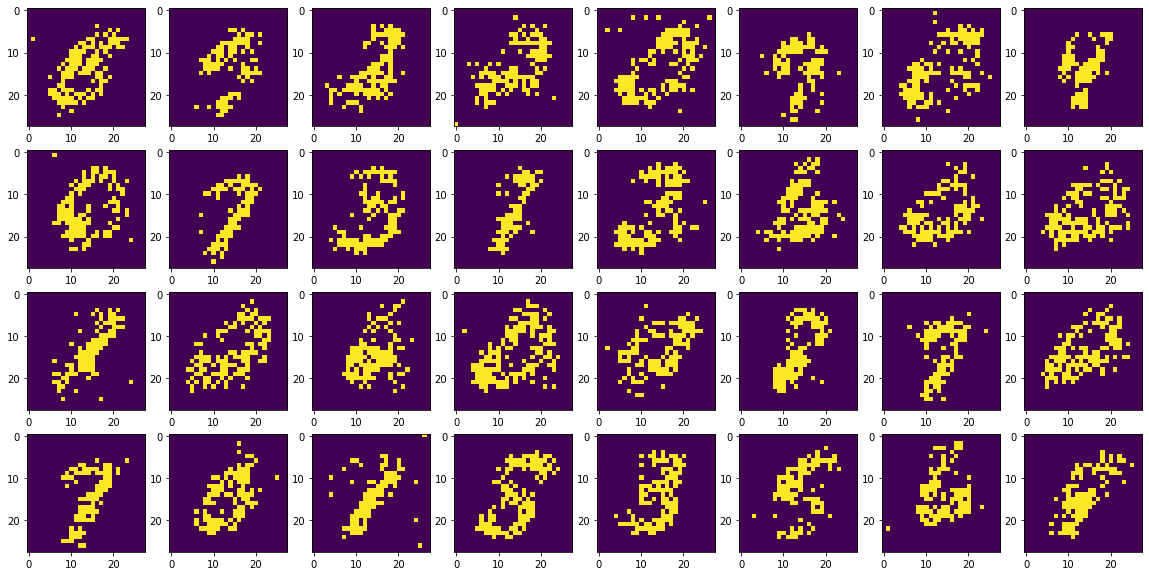

In [539]:
# RBM digits for 20 hidden nodes

plt.figure(figsize=(20,10))
for i in range(0, len(v)):
    plt.subplot(4, 8,i+1)
    plt.imshow(np.transpose(v1.view(32,1,28,28).data[i].numpy(),(1,2,0)))
plt.show()

In [487]:
train_op = optim.SGD(rbm100.parameters(), 0.01)

for epoch in range(10):
    loss_ = []
    for _, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, 784))
        sample_data = data.bernoulli()
        v, v1 = rbm100(sample_data)
        loss = rbm100.free_energy(v) - rbm100.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -50.752647399902344
Training loss for 1 epoch: -22.042522430419922
Training loss for 2 epoch: -19.621564865112305
Training loss for 3 epoch: -18.371435165405273
Training loss for 4 epoch: -17.915559768676758
Training loss for 5 epoch: -17.458524703979492
Training loss for 6 epoch: -16.79718017578125
Training loss for 7 epoch: -16.313528060913086
Training loss for 8 epoch: -15.83475399017334
Training loss for 9 epoch: -15.391560554504395


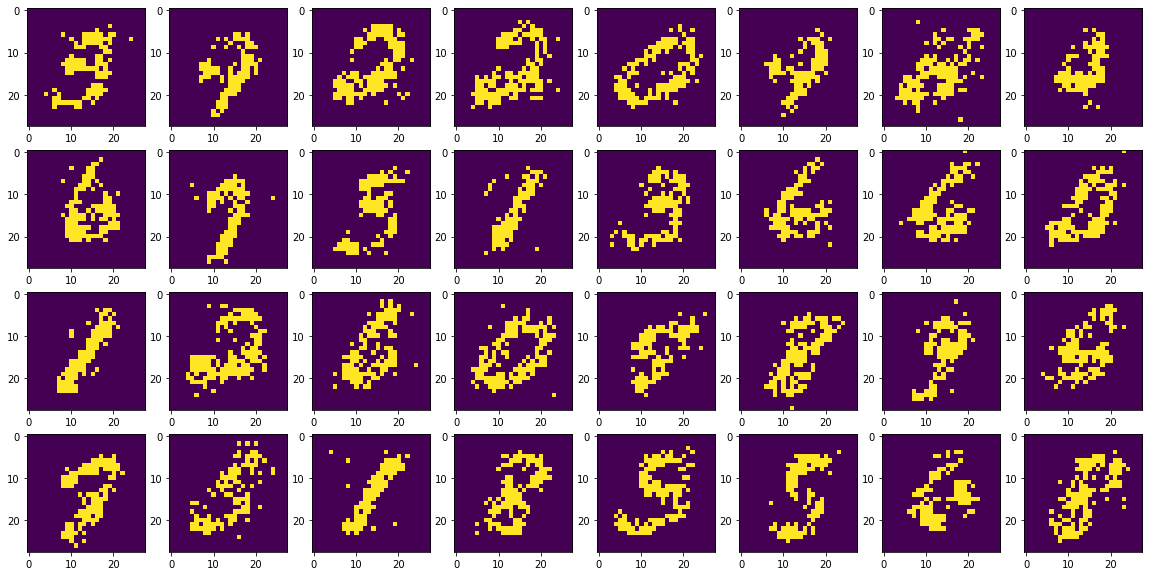

In [491]:
# RBM digits for 100 hidden nodes

plt.figure(figsize=(20,10))
for i in range(0, len(v)):
    plt.subplot(4, 8,i+1)
    plt.imshow(np.transpose(v1.view(32,1,28,28).data[i].numpy(),(1,2,0)))
plt.show()

In [493]:
train_op = optim.SGD(rbm500.parameters(), 0.01)

for epoch in range(10):
    loss_ = []
    for _, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, 784))
        sample_data = data.bernoulli()
        v, v1 = rbm500(sample_data)
        loss = rbm500.free_energy(v) - rbm500.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -19.550230026245117
Training loss for 1 epoch: -15.009061813354492
Training loss for 2 epoch: -14.447288513183594
Training loss for 3 epoch: -13.390992164611816
Training loss for 4 epoch: -13.13158130645752
Training loss for 5 epoch: -12.336539268493652
Training loss for 6 epoch: -11.676697731018066
Training loss for 7 epoch: -11.015362739562988
Training loss for 8 epoch: -10.44247817993164
Training loss for 9 epoch: -9.995903015136719


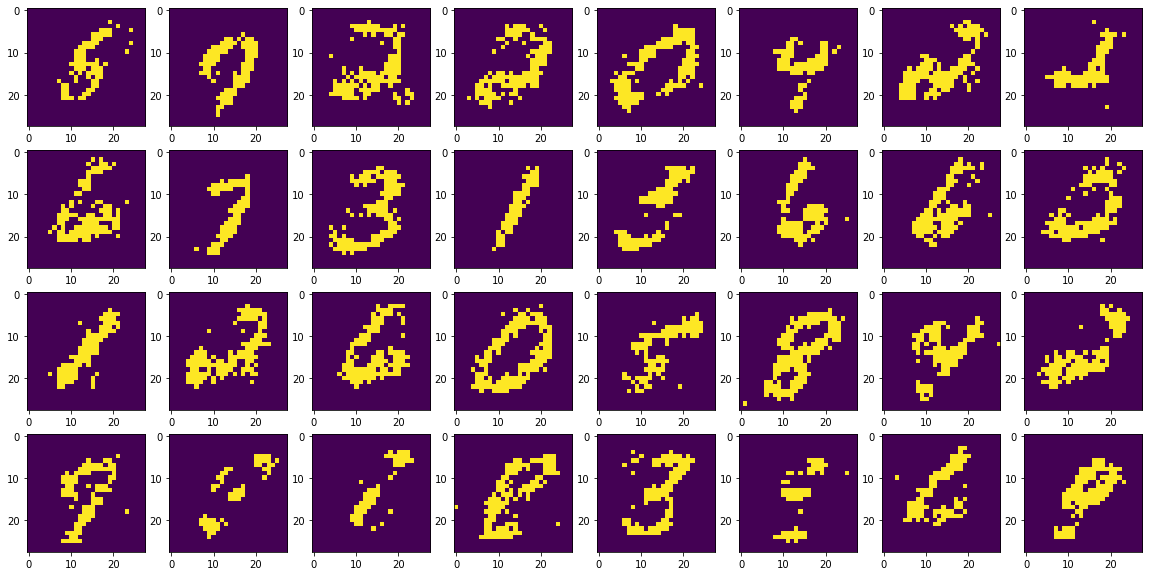

In [494]:
# RBM digits for 500 hidden nodes

plt.figure(figsize=(20,10))
for i in range(0, len(v)):
    plt.subplot(4, 8,i+1)
    plt.imshow(np.transpose(v1.view(32,1,28,28).data[i].numpy(),(1,2,0)))
plt.show()

## Using built in RBM Functions:

In [400]:
rbm20 = BernoulliRBM(n_components = 20, learning_rate = 0.01, random_state = 0, verbose = True) # RBM with 20 hidden nodes
rbm100 = BernoulliRBM(n_components = 100, learning_rate = 0.01, random_state = 0, verbose = True) # RBM with 100 hidden nodes
rbm500 = BernoulliRBM(n_components = 500, learning_rate = 0.01, random_state = 0, verbose = True) # RBM with 500 hidden nodes

In [401]:
rbm20.fit(x_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -198.66, time = 2.02s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -190.78, time = 2.64s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -183.51, time = 2.51s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -172.89, time = 2.55s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -166.96, time = 2.52s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -165.83, time = 2.43s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -161.50, time = 2.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -155.79, time = 2.52s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -150.00, time = 2.46s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -147.98, time = 2.36s


BernoulliRBM(learning_rate=0.01, n_components=20, random_state=0, verbose=True)

In [402]:
rbm100.fit(x_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -113.09, time = 7.46s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -99.82, time = 8.55s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -92.08, time = 9.07s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -88.48, time = 8.67s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -84.99, time = 9.28s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -83.88, time = 9.35s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -82.54, time = 8.55s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -80.91, time = 7.65s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -80.23, time = 8.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -79.90, time = 8.11s


BernoulliRBM(learning_rate=0.01, n_components=100, random_state=0, verbose=True)

In [403]:
rbm500.fit(x_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -88.25, time = 25.39s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -80.26, time = 28.55s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -73.82, time = 28.44s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -70.41, time = 27.69s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -69.24, time = 27.62s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -67.76, time = 27.86s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -66.57, time = 27.47s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -66.06, time = 28.38s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -65.67, time = 29.66s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -64.66, time = 28.14s


BernoulliRBM(learning_rate=0.01, n_components=500, random_state=0, verbose=True)

In [404]:
def Gibbs(epochs, x_train, rbm):
    count = 0
    while count < epochs:
        gibbs = rbm.gibbs(x_train)
        x_train = np.zeros_like(x_train)
        x_train[gibbs] = 1 
        count += 1
    return x_train

In [405]:
x_train_20 = Gibbs(10, x_train[:50], rbm20)
x_train_100 = Gibbs(10, x_train[:50], rbm100)
x_train_500 = Gibbs(10, x_train[:50], rbm100)

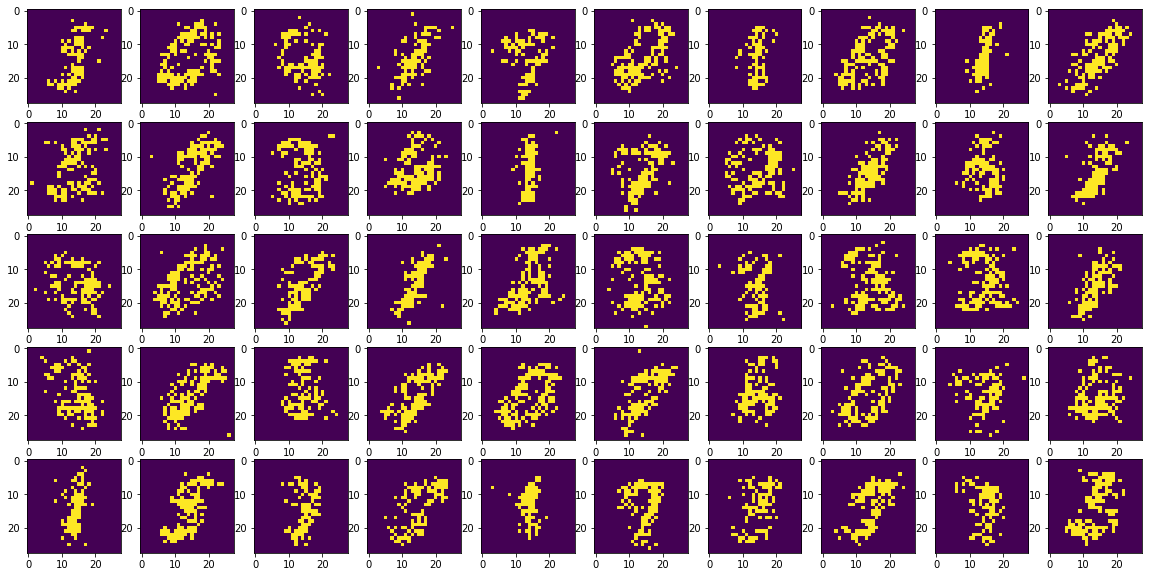

In [406]:
# Generating digits for 20 hidden nodes

plt.figure(figsize=(20,10))
for i in range(0, len(x_train_20)):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train_20[i].reshape((28, 28)))
plt.show()

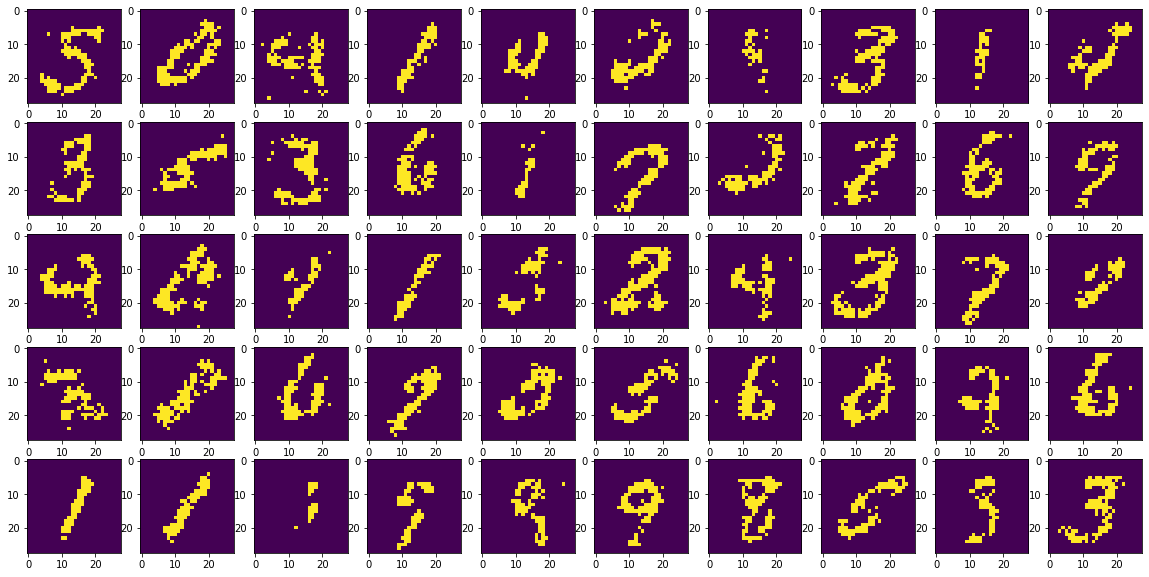

In [407]:
# Generating digits for 100 hidden nodes

plt.figure(figsize=(20,10))
for i in range(0, len(x_train_100)):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train_100[i].reshape((28, 28)))
plt.show()

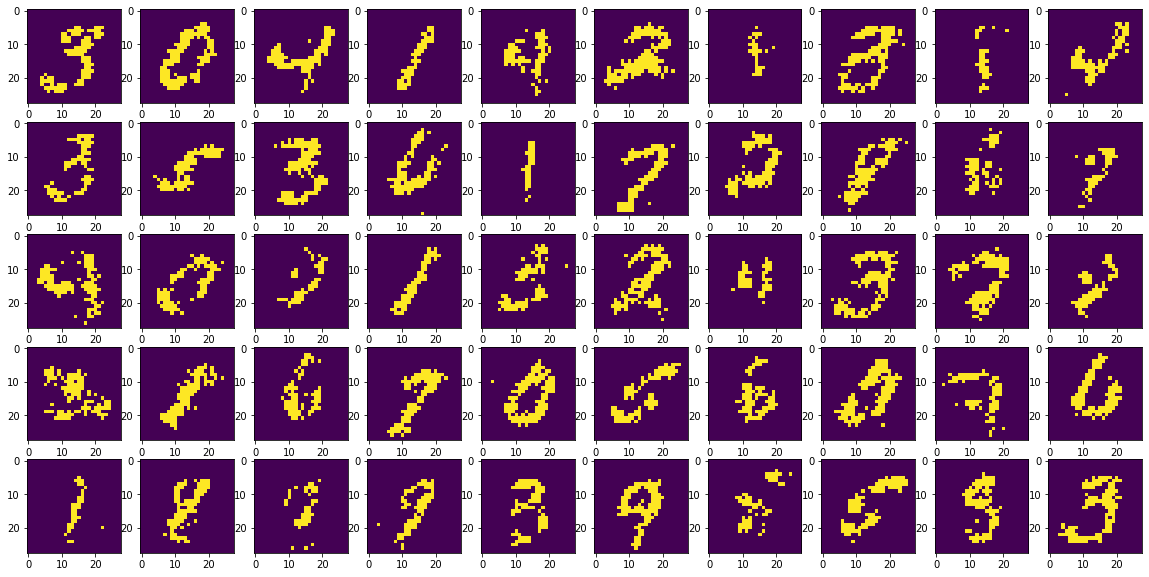

In [408]:
# Generating digits for 500 hidden nodes

plt.figure(figsize=(20,10))
for i in range(0, len(x_train_500)):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train_500[i].reshape((28, 28)))
plt.show()

## (c) Generate MNIST images from the ones in the testing data set that have 20%, 50% and 80% pixels missing/removed. It means you are going to train the RBM with those degraded images.

In [594]:
def Degrade(x_test, percent):
    remove = (percent * 784)/100
    pixels = [np.random.randint(0,783) for i in range(int(remove))]
    for x in range(len(x_test)):
        for i in pixels:
            x_test[x][i] = 0
    return x_test

## Without Using built in RBM Functions:

In [595]:
rbm = RBM()

In [596]:
train_op = optim.SGD(rbm.parameters(), 0.01)

for epoch in range(10):
    loss_ = []
    for _, (data, target) in enumerate(test_loader):
        data = Variable(data.view(-1, 784))
        data =  Degrade(data, 20)
        sample_data = data.bernoulli()
        v, v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Testing loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Testing loss for 0 epoch: -46.50018310546875
Testing loss for 1 epoch: -4.4310526847839355
Testing loss for 2 epoch: -9.97883129119873
Testing loss for 3 epoch: -7.271045684814453
Testing loss for 4 epoch: -7.643019676208496
Testing loss for 5 epoch: -8.453038215637207
Testing loss for 6 epoch: -8.666276931762695
Testing loss for 7 epoch: -7.239781856536865
Testing loss for 8 epoch: -6.946393013000488
Testing loss for 9 epoch: -7.268097400665283


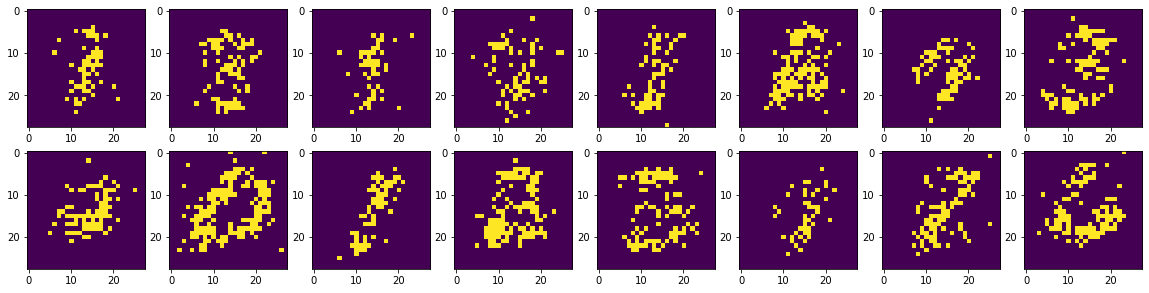

In [638]:
# Generating digits for 20% pixel loss

plt.figure(figsize=(20,10))
for i in range(0, len(v1)):
    plt.subplot(4, 8,i+1)
    plt.imshow(v1[i].detach().numpy().reshape((28, 28)))
plt.show()

In [639]:
rbm = RBM()

In [640]:
train_op = optim.SGD(rbm.parameters(), 0.01)

for epoch in range(10):
    loss_ = []
    for _, (data, target) in enumerate(test_loader):
        data = Variable(data.view(-1, 784))
        data =  Degrade(data, 50)
        sample_data = data.bernoulli()
        v, v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Testing loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Testing loss for 0 epoch: -58.05604934692383
Testing loss for 1 epoch: -0.43094417452812195
Testing loss for 2 epoch: 2.100226879119873
Testing loss for 3 epoch: -0.04197673499584198
Testing loss for 4 epoch: -4.134930610656738
Testing loss for 5 epoch: -1.1720762252807617
Testing loss for 6 epoch: -0.5233269929885864
Testing loss for 7 epoch: -0.5536665916442871
Testing loss for 8 epoch: -2.0606658458709717
Testing loss for 9 epoch: -2.3603899478912354


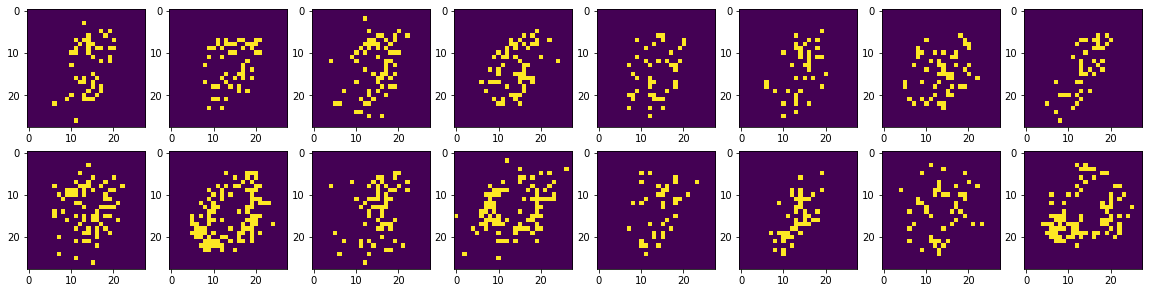

In [641]:
# Generating digits for 50% pixel loss

plt.figure(figsize=(20,10))
for i in range(0, len(v1)):
    plt.subplot(4, 8,i+1)
    plt.imshow(v1[i].detach().numpy().reshape((28, 28)))
plt.show()

In [642]:
rbm = RBM()

In [643]:
train_op = optim.SGD(rbm.parameters(), 0.01)

for epoch in range(10):
    loss_ = []
    for _, (data, target) in enumerate(test_loader):
        data = Variable(data.view(-1, 784))
        data =  Degrade(data, 80)
        sample_data = data.bernoulli()
        v, v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Testing loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Testing loss for 0 epoch: -65.95283508300781
Testing loss for 1 epoch: -0.48404940962791443
Testing loss for 2 epoch: 3.076110363006592
Testing loss for 3 epoch: 3.8783884048461914
Testing loss for 4 epoch: 4.23582649230957
Testing loss for 5 epoch: 3.9394710063934326
Testing loss for 6 epoch: 2.553001880645752
Testing loss for 7 epoch: 0.3203311562538147
Testing loss for 8 epoch: -0.3689406216144562
Testing loss for 9 epoch: 0.9338585734367371


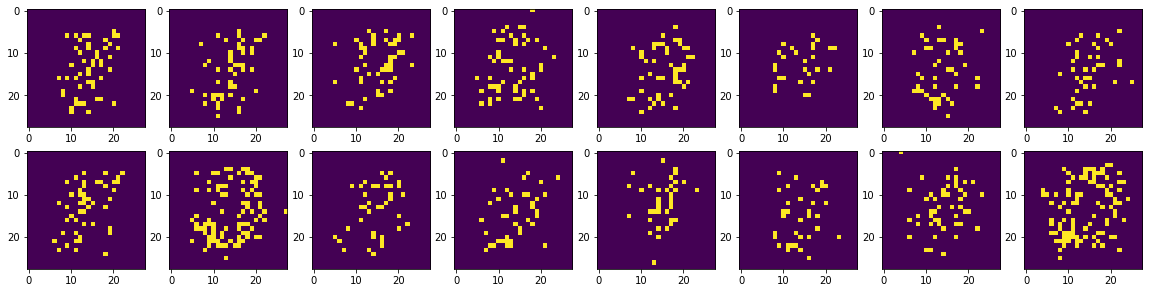

In [644]:
# Generating digits for 20% pixel loss

plt.figure(figsize=(20,10))
for i in range(0, len(v1)):
    plt.subplot(4, 8,i+1)
    plt.imshow(v1[i].detach().numpy().reshape((28, 28)))
plt.show()

## Using built in RBM Functions:

In [410]:
x_test_20 = x_test.copy()
x_test_50 = x_test.copy()
x_test_80 = x_test.copy()
x_test_20 = Degrade(x_test_20, 20)
x_test_50 = Degrade(x_test_50, 50)
x_test_80 = Degrade(x_test_80, 80)

In [411]:
rbm20 = BernoulliRBM(n_components = 500, learning_rate = 0.01, random_state = 0, verbose = True) 
rbm50 = BernoulliRBM(n_components = 500, learning_rate = 0.01, random_state = 0, verbose = True) 
rbm80 = BernoulliRBM(n_components = 500, learning_rate = 0.01, random_state = 0, verbose = True) 

In [412]:
rbm20.fit(x_test_20)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -117.98, time = 4.21s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -100.75, time = 5.24s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -90.77, time = 4.85s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -83.16, time = 5.15s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -79.35, time = 4.79s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -75.85, time = 4.64s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -71.98, time = 4.57s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -71.85, time = 4.65s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -68.98, time = 4.62s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -68.59, time = 4.62s


BernoulliRBM(learning_rate=0.01, n_components=500, random_state=0, verbose=True)

In [413]:
rbm50.fit(x_test_50)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -99.12, time = 4.12s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -77.16, time = 4.68s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -69.15, time = 4.81s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -65.46, time = 4.69s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -60.94, time = 4.72s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -59.92, time = 4.70s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -56.48, time = 4.64s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -57.01, time = 4.74s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -55.45, time = 4.64s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -54.62, time = 4.83s


BernoulliRBM(learning_rate=0.01, n_components=500, random_state=0, verbose=True)

In [414]:
rbm80.fit(x_test_80)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -76.08, time = 4.20s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -62.48, time = 4.73s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -57.11, time = 4.66s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -51.94, time = 4.73s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -49.29, time = 5.19s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -48.37, time = 4.88s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -46.84, time = 4.63s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -44.59, time = 4.59s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -42.40, time = 4.64s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -46.53, time = 4.55s


BernoulliRBM(learning_rate=0.01, n_components=500, random_state=0, verbose=True)

In [415]:
x_20 = Gibbs(10, x_test_20[:50], rbm20)
x_50 = Gibbs(10, x_test_50[:50], rbm50)
x_80 = Gibbs(10, x_test_80[:50], rbm80)

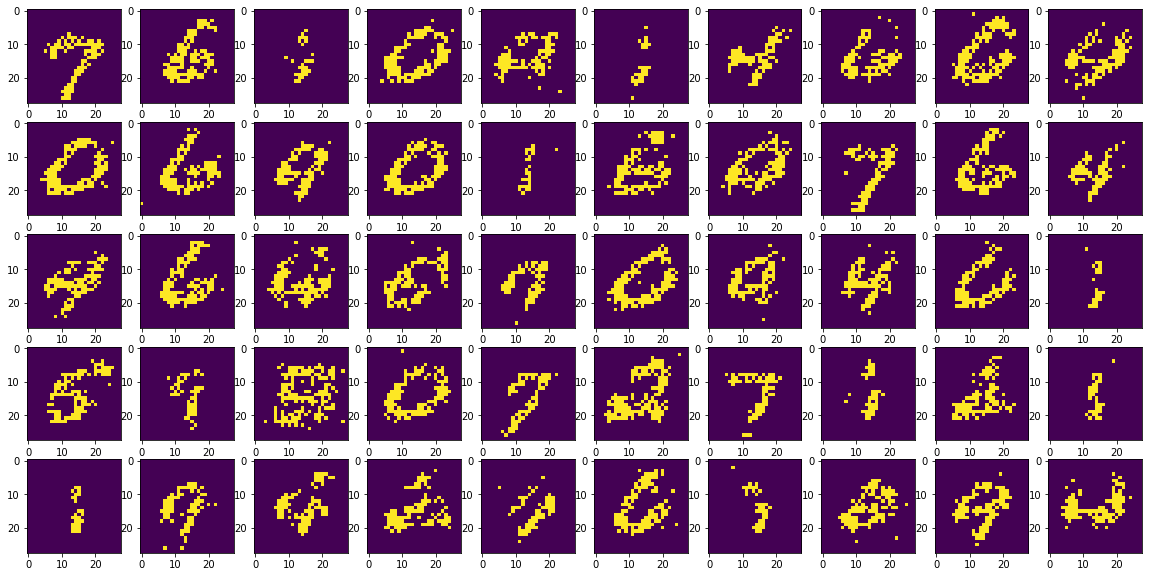

In [416]:
# Generating digits for 20% degraded image

plt.figure(figsize=(20,10))
for i in range(0, len(x_20)):
    plt.subplot(5,10,i+1)
    plt.imshow(x_20[i].reshape((28, 28)))
plt.show()

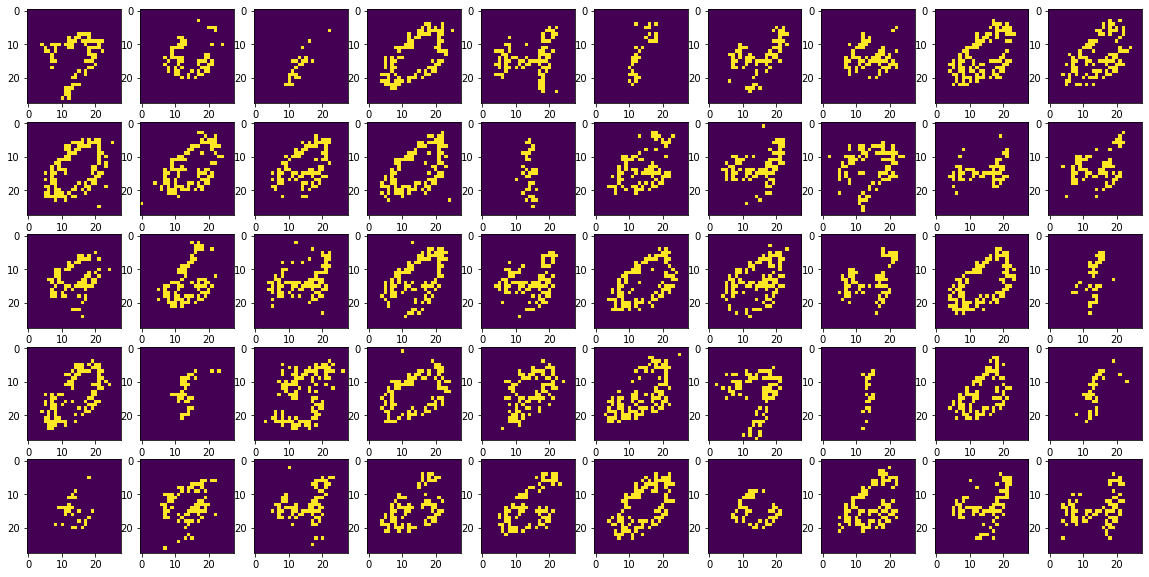

In [417]:
# Generating digits for 50% degraded image

plt.figure(figsize=(20,10))
for i in range(0, len(x_50)):
    plt.subplot(5,10,i+1)
    plt.imshow(x_50[i].reshape((28, 28)))
plt.show()

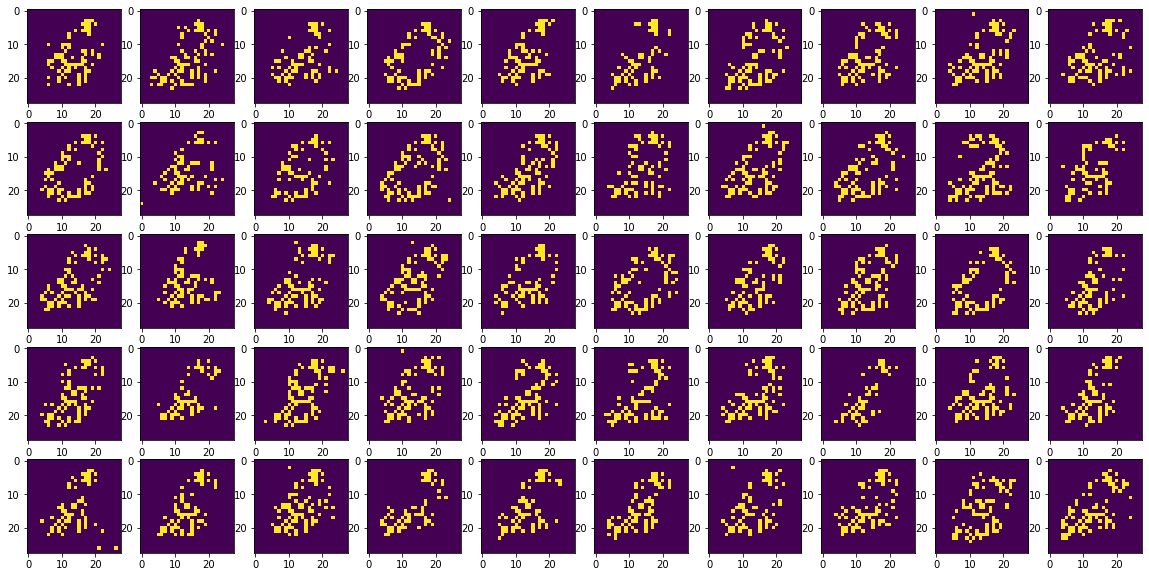

In [418]:
# Generating digits for 80% degraded image

plt.figure(figsize=(20,10))
for i in range(0, len(x_80)):
    plt.subplot(5,10,i+1)
    plt.imshow(x_80[i].reshape((28, 28)))
plt.show()

# 2) Task-2

## (a) Derive the variational autoencoder algorithm that you will implement, and explain your derivation.

$X$ -> observation, $Z$ -> hidden variable. 
$P\left( z|x \right)$ =

$$P\left( z|x \right) = \frac{P\left(x|z\right) P(z)}{P(x)}$$
$$ = \frac{P\left(x,z\right)}{P(x)}$$

Let's approximate $P\left(z|x\right)$ using another distribution - $q(z)$. If we choose $q$ to be a tractable distribution (Gaussian, exponential, etc), we can tune the parameters of the distribution in a way that the $q$ becomes close to the original distribution. 

In order to make distribution $q$ similar to distribution $P$, the idea of KL-divergence can be helpful. KL-divergence provides information about the similarity/dissimlarity between two distributions and is unsymmetric in nature. 

Computing the value of $P(x)$ is quite complicated because it is an integral of all the values $P\left(x|z\right) P(z)$ and in case of high dimensional features, i.e large dimenzional $z$, the computation of the integral becomes very computationally expensive. We can solve this problem using the Monte-Carlo Approach and another approach called Variational Inference.



If we minimize the KL-divergence, we can make $q$ similar to $p$.

$$\therefore KL\left(q(z)||P(z|x)\right) = - \sum q\left(z\right) log \frac{P(z|x)}{q(z)}$$ 
$$ = - \sum q(z) log \frac{\frac{P(x,z)}{P(x)}}{q(z)}$$
$$ = - \sum q(z) log \frac{P(x,z)}{q(z)} .\frac {1}{P(x)}$$
$$ = - \sum q(z) \left[log \frac{P(x,z)}{q(z)} - log P(x)\right]$$
$$ = - \sum q(z) log \frac{P(x,z)}{q(z)} + \sum_{z} q(z) log P(x)$$
$$ = - \sum q(z) log \frac{P(x,z)}{q(z)} + log P(x) \sum_{z} q(z)$$
$$ = - \sum q(z) log \frac{P(x,z)}{q(z)} + log P(x)$$, as $\sum_{z} q(z) = 1$
<br>
<br>

$$log P(x) = KL\left(q(z) || P(z|x)\right) + \sum q(z) log\frac{ P\left(x,z\right)}{q(z)}$$

Let the second term on RHS be $L$. Now, $log P(x)$ is a constant and we want to minimize the KL divergence. $$\therefore constant = KL-divergence + L$$
Thus, to maintain the constant, we can maximize $L$ to maximize the KL-divergence. $L$ is called variational-lower bound and $L <= P(x)$. 

Lower Bound -> 

$$\sum q(z) log \frac{P(x,z)}{q(z)}$$
$$ = \sum q(z) log \frac{P(x|z) P(z)}{q(z)}$$
$$ = \sum q(z) \left[log P(x|z) + \frac{P(z)}{q(z)}\right]$$
$$ = \sum q(z) log P(x|z) \sum q(z) log\frac{P(z)}{q(z)}$$

The second sum quantity is negative KL-divergence between $q(z)$ and $P(z)$, the first term is the Expectation of $log P(x|z)$ w.r.t $q(z)$.

Objective Function - > 

$$ = E_{q(z)} log P(x|z) - KL \left( q(z) || P(z) \right)$$ 

We will design an Auto-Encoder using the lower bound:

Assuming $q$ is a Neural Network, a function that maps $x$ to $z$, i.e. takes input $x$ and maps it to $z$. Then, we assume that $P$ is another neural network that takes input $z$ and maps it to $x^{'}$. In other words we have - 

Auto-Encoder -> 

$$ x \rightarrow NN \left(q(z|x)\right) \rightarrow z \rightarrow NN \left(p(x|z)\right) \rightarrow x^{'} $$


Let's assume that $z$ has a Gaussian distribution. We have an auto-encoder as a part of our objective function that tells us to make a distribution similar to another distribution that we need to choose, which we have chosen as a Gaussian distribution. 

The first part of our objective function is actually a construction error. 

Since the second NN is a deterministic model, the relationship between $z$ and $x^{'}$ will always remain the same. Thus, $P(x|z)$ can be written as $P(x|x^{'})$ . Since the distribution is Gaussian, then it is of the form, 

$$P(x|x^{'}) = e^{-\left|x-x^{'}\right|^{2}}$$

Takin log, we get
$$\left|x-x^{'}\right|^2$$

So, now we have a auto-encoder, with a cost function to minimze the distance between we observe as -

$$min  \left|x-x^{'}\right|^{2} + KL\left( q(z|x) || N(    )\right)$$, where $N(    )$ is the Gaussian Distribution in most cases

But, we have a Graphical model, and all we have are random variables. So, things are not necessarily deterministic. We need to design our network in such a way that it doesn't generate the code of $z$ rather generates the parameter of the distribution that generates the code. 

So,$z$ has a Normal distribution with 2 parameters -  $\mu$ and $\sigma$. $\mu$ is a D-dimensional vector and $\sigma$ is DxD, consider a diagonal matrix for simplicity. 

We force or train the network to generate the mean of this distribution and the variance of this distribution. We sample the distribution and pass it to the second Neural Network and generate $x^{'}$. 

We can use this model as a Generative Model. After the training is done, we get $z$ with a $\mu$ and $\sigma$. We sample from $z$ and feed it to the second neural network and get points similar to what we have observed to produce the Variational Auto-Encoder

## (b) Implement the training and inference algorithms for VAE. Train VAE with 2, 8 and 16 code units to encode MNIST images using the training data set. Code units are the nodes in the bottleneck layer in the middle.  The neural network will be 784 input → 256 hidden → 2/8/16 code → 256 hidden → 784 output. 

In [121]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [122]:
train_data = np.loadtxt("Dataset/mnist_train.csv", delimiter=",")
test_data = np.loadtxt("Dataset/mnist_test.csv", delimiter=",")

In [123]:
# Train test split

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(train_data)):
    x_train.append(train_data[i][1:])
    y_train.append(train_data[i][:1])
for i in range(len(test_data)):
    x_test.append(test_data[i][1:])
    y_test.append(test_data[i][:1])
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [124]:
# Implementing 0-1 Scaler

# Finding Z
for i in range(len(x_train)):
    x_train[i] = (x_train[i] -  np.min(x_train[i], 0)) / (np.max(x_train[i], 0) - np.min(x_train[i], 0)) + 0.0001

for i in range(len(x_test)):
    x_test[i] = (x_test[i] -  np.min(x_test[i], 0)) / (np.max(x_test[i], 0) - np.min(x_test[i], 0)) + 0.0001

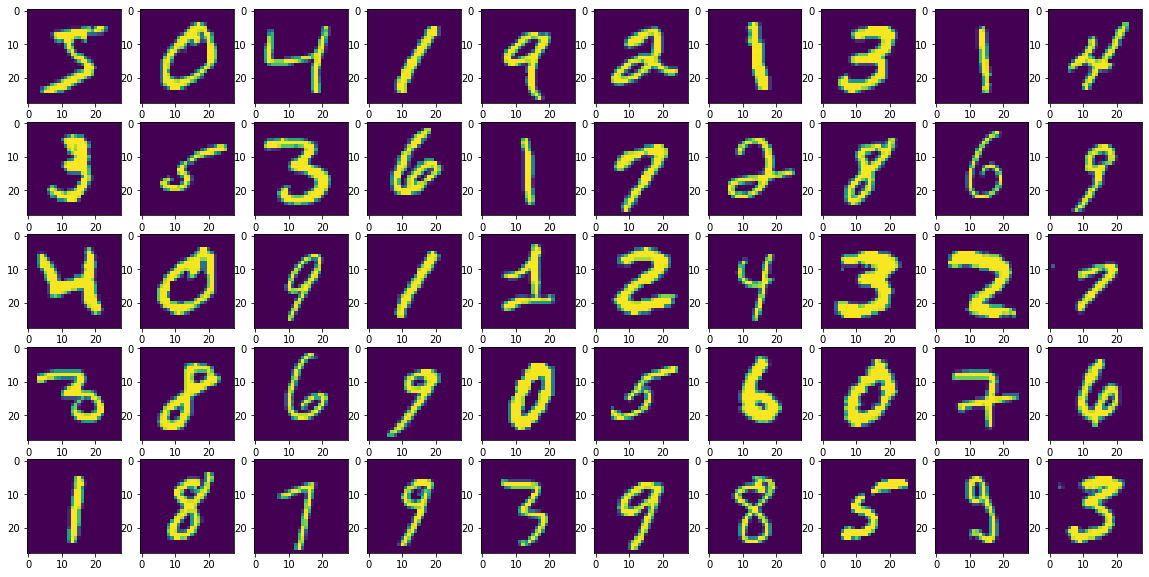

In [125]:
plt.figure(figsize=(20,10))
for i in range(0, len(x_train[:50])):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train[i].reshape((28, 28)))
plt.show()

In [192]:
def GaussianSampling(args):
    mean, log_variance = args
    batch = K.shape(mean)[0]
    dimensions = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape = (batch, dimensions))
    sample = mean + K.exp(0.5 * log_variance) * epsilon
    
    return sample

In [193]:
def Encoder(inputs, code):
    x = Dense(256, activation = 'relu')(inputs)
    mean = Dense(code)(x)
    log_variance = Dense(code)(x)
    z = Lambda(GaussianSampling, output_shape = (code,))([mean, log_variance])
    encoder = Model(inputs, [mean, log_variance, z])
    
    return encoder, mean, log_variance

In [194]:
def Decoder(code):
    latent_inputs = Input(shape = (code,))
    x = Dense(256, activation = 'relu')(latent_inputs)
    outputs = Dense(784, activation = 'sigmoid')(x)
    decoder = Model(latent_inputs, outputs)
    
    return decoder

### When Code = 2

In [195]:
inputs = Input(shape = (784,))
encoder, mean, log_variance = Encoder(inputs, code = 2)
decoder = Decoder(code = 2)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
encoder.summary()
decoder.summary()
vae.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 256)          200960      input_17[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 2)            514         dense_36[0][0]                   
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 2)            514         dense_36[0][0]                   
___________________________________________________________________________________________

In [196]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + log_variance - K.square(mean) - K.exp(log_variance)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [197]:
vae.fit(x_train, epochs = 10, batch_size = 128, validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 208us/sample - loss: 206.0391 - val_loss: 178.2515
Epoch 2/10
60000/60000 [==============================] - 11s 183us/sample - loss: 173.5837 - val_loss: 169.6203
Epoch 3/10
60000/60000 [==============================] - 11s 180us/sample - loss: 167.9944 - val_loss: 166.7699
Epoch 4/10
60000/60000 [==============================] - 11s 179us/sample - loss: 165.5362 - val_loss: 164.7180
Epoch 5/10
60000/60000 [==============================] - 11s 179us/sample - loss: 163.9153 - val_loss: 163.3072
Epoch 6/10
60000/60000 [==============================] - 11s 182us/sample - loss: 162.5579 - val_loss: 162.1131
Epoch 7/10
60000/60000 [==============================] - 11s 180us/sample - loss: 161.3491 - val_loss: 160.8342
Epoch 8/10
60000/60000 [==============================] - 11s 183us/sample - loss: 160.2107 - val_loss: 159.9250
Epoch 9/10
60000/60000 [======================

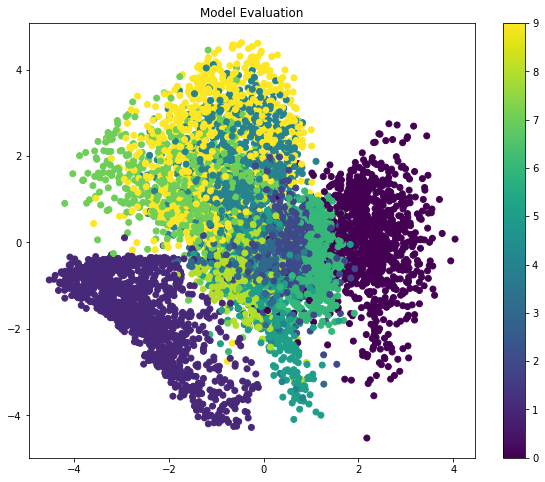

In [201]:
mean, _, _ = encoder.predict(x_test, batch_size = 128)
plt.figure(figsize=(10, 8))
plt.scatter(mean[:, 0], mean[:, 1], c = y_test)
plt.colorbar()
plt.title("Model Evaluation")
plt.show()

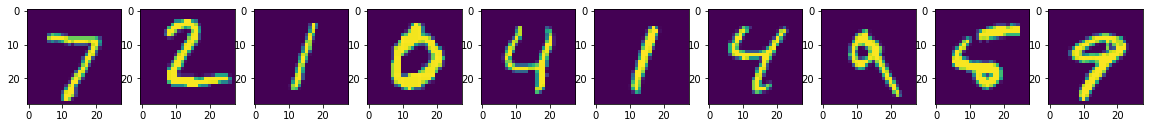

In [219]:
# Real Images
plt.figure(figsize=(20,10))
for i in range(0, len(x_test[:10])):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].reshape((28, 28)))
plt.show()

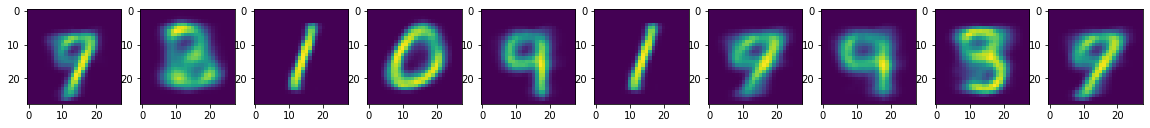

In [220]:
# Generated Images
plt.figure(figsize=(20,10))
for i in range(0, len(x_test[:10])):
    plt.subplot(2, 10, i+1)
    x = np.expand_dims(x_test[i], axis = 0)
    m, v, z = encoder.predict(x)
    y = decoder.predict(m)
    plt.imshow(y.reshape((28, 28)))
plt.show()

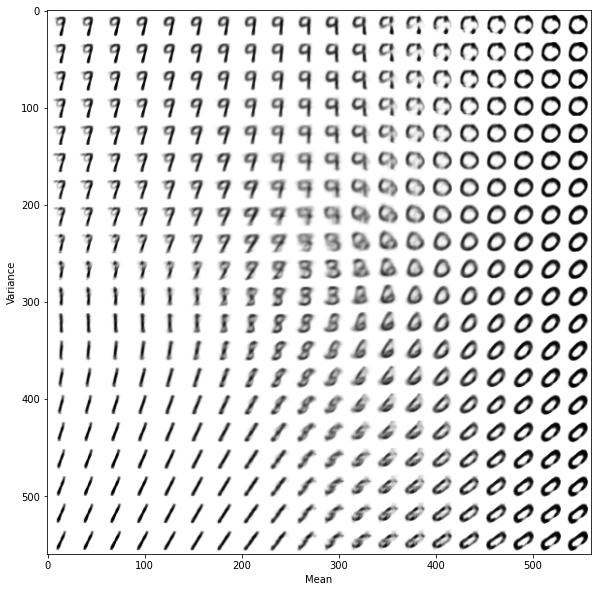

In [232]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.linspace(-4, 4, 20)
grid_y = np.linspace(-4, 4, 20)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        xd = decoder.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

### When Code = 8

In [233]:
inputs = Input(shape = (784,))
encoder, mean, log_variance = Encoder(inputs, code = 8)
decoder = Decoder(code = 8)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
encoder.summary()
decoder.summary()
vae.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 256)          200960      input_19[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 8)            2056        dense_41[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 8)            2056        dense_41[0][0]                   
___________________________________________________________________________________________

In [234]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + log_variance - K.square(mean) - K.exp(log_variance)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [235]:
vae.fit(x_train, epochs = 10, batch_size = 128, validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 212us/sample - loss: 176.0035 - val_loss: 138.7830
Epoch 2/10
60000/60000 [==============================] - 12s 195us/sample - loss: 134.0156 - val_loss: 128.9798
Epoch 3/10
60000/60000 [==============================] - 11s 189us/sample - loss: 127.8576 - val_loss: 125.2976
Epoch 4/10
60000/60000 [==============================] - 11s 190us/sample - loss: 124.9099 - val_loss: 122.9564
Epoch 5/10
60000/60000 [==============================] - 11s 189us/sample - loss: 123.0252 - val_loss: 121.3981
Epoch 6/10
60000/60000 [==============================] - 11s 190us/sample - loss: 121.6393 - val_loss: 120.2046
Epoch 7/10
60000/60000 [==============================] - 11s 189us/sample - loss: 120.5658 - val_loss: 119.3649
Epoch 8/10
60000/60000 [==============================] - 11s 191us/sample - loss: 119.6796 - val_loss: 118.4748
Epoch 9/10
60000/60000 [======================

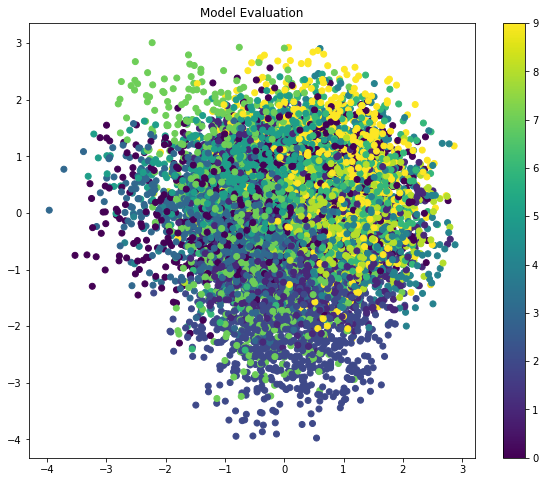

In [236]:
mean, _, _ = encoder.predict(x_test, batch_size = 128)
plt.figure(figsize=(10, 8))
plt.scatter(mean[:, 0], mean[:, 1], c = y_test)
plt.colorbar()
plt.title("Model Evaluation")
plt.show()

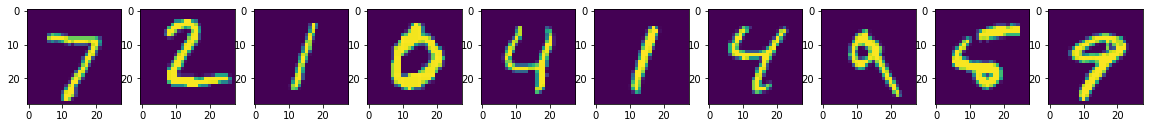

In [237]:
# Real Images
plt.figure(figsize=(20,10))
for i in range(0, len(x_test[:10])):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].reshape((28, 28)))
plt.show()

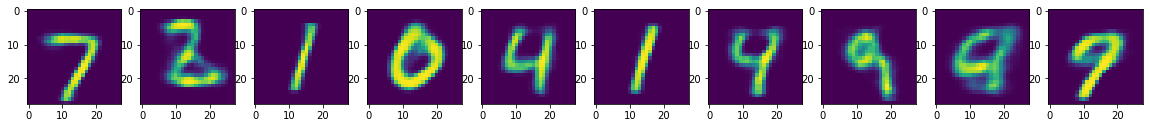

In [238]:
# Generated Images
plt.figure(figsize=(20,10))
for i in range(0, len(x_test[:10])):
    plt.subplot(2, 10, i+1)
    x = np.expand_dims(x_test[i], axis = 0)
    m, v, z = encoder.predict(x)
    y = decoder.predict(m)
    plt.imshow(y.reshape((28, 28)))
plt.show()

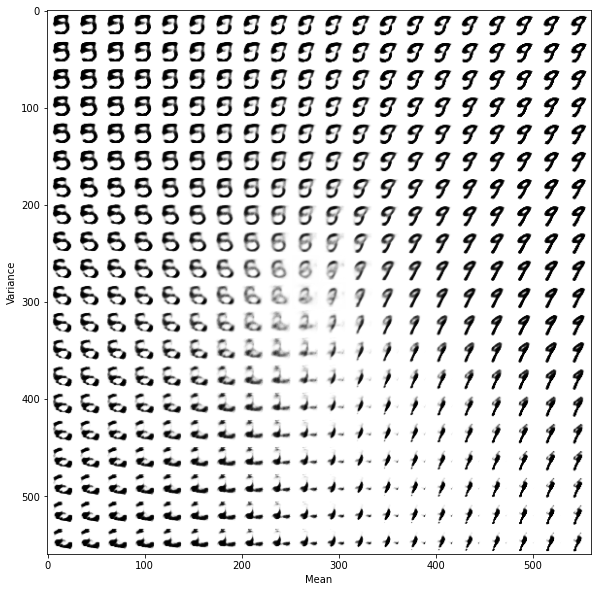

In [249]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.linspace(-4, 4, 20)
grid_y = np.linspace(-4, 4, 20)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi] * 4])
        xd = decoder.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

### When Code = 16

In [250]:
inputs = Input(shape = (784,))
encoder, mean, log_variance = Encoder(inputs, code = 16)
decoder = Decoder(code = 16)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
encoder.summary()
decoder.summary()
vae.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 256)          200960      input_21[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 16)           4112        dense_46[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 16)           4112        dense_46[0][0]                   
___________________________________________________________________________________________

In [251]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + log_variance - K.square(mean) - K.exp(log_variance)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [252]:
vae.fit(x_train, epochs = 10, batch_size = 128, validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 222us/sample - loss: 175.1485 - val_loss: 133.7298
Epoch 2/10
60000/60000 [==============================] - 12s 198us/sample - loss: 127.6120 - val_loss: 121.5037
Epoch 3/10
60000/60000 [==============================] - 12s 197us/sample - loss: 120.2932 - val_loss: 117.0446
Epoch 4/10
60000/60000 [==============================] - 12s 197us/sample - loss: 116.7473 - val_loss: 114.5935
Epoch 5/10
60000/60000 [==============================] - 12s 197us/sample - loss: 114.5343 - val_loss: 112.6564
Epoch 6/10
60000/60000 [==============================] - 12s 197us/sample - loss: 112.9592 - val_loss: 111.4794
Epoch 7/10
60000/60000 [==============================] - 12s 197us/sample - loss: 111.7983 - val_loss: 110.5608
Epoch 8/10
60000/60000 [==============================] - 12s 200us/sample - loss: 110.9397 - val_loss: 109.8818
Epoch 9/10
60000/60000 [======================

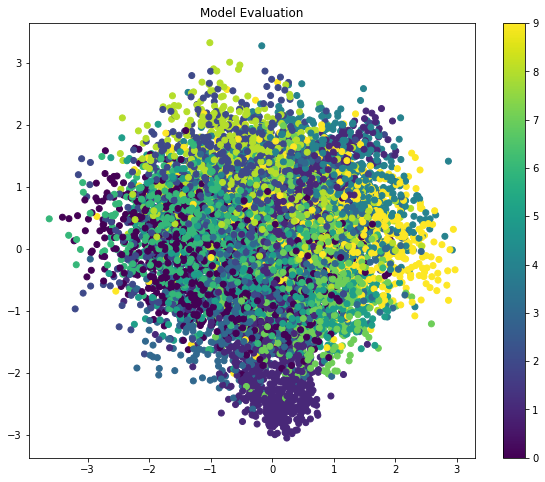

In [253]:
mean, _, _ = encoder.predict(x_test, batch_size = 128)
plt.figure(figsize=(10, 8))
plt.scatter(mean[:, 0], mean[:, 1], c = y_test)
plt.colorbar()
plt.title("Model Evaluation")
plt.show()

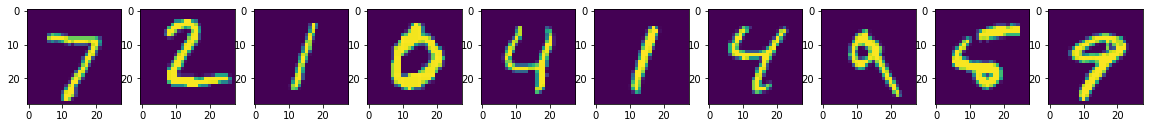

In [254]:
# Real Images
plt.figure(figsize=(20,10))
for i in range(0, len(x_test[:10])):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].reshape((28, 28)))
plt.show()

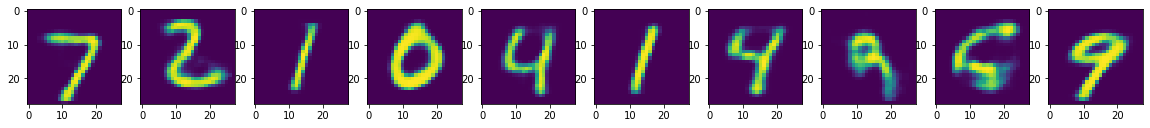

In [255]:
# Generated Images
plt.figure(figsize=(20,10))
for i in range(0, len(x_test[:10])):
    plt.subplot(2, 10, i+1)
    x = np.expand_dims(x_test[i], axis = 0)
    m, v, z = encoder.predict(x)
    y = decoder.predict(m)
    plt.imshow(y.reshape((28, 28)))
plt.show()

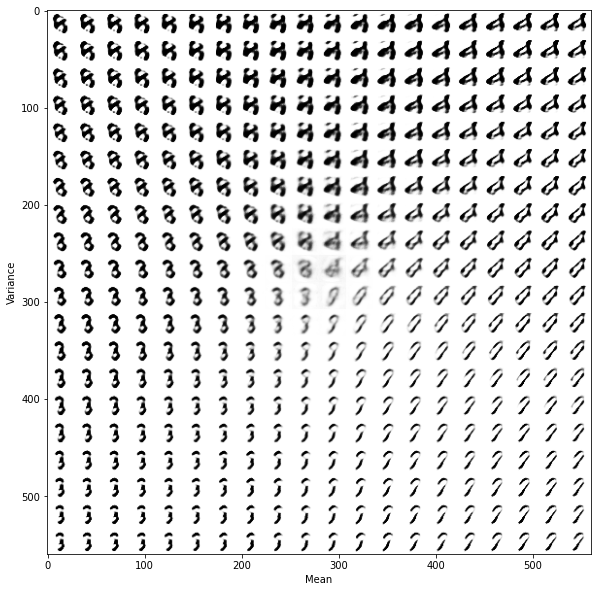

In [256]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.linspace(-4, 4, 20)
grid_y = np.linspace(-4, 4, 20)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi] * 8])
        xd = decoder.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

## (c) Then use the 2 code → 256 hidden → 784 output part of the trained network to generate images by varying each of the 2 code units from -3 to 3. It means you are going to choose two random values in the range of [-3,3] and pass those two values to the 2 code units. Try three different pair of values and output the results. You do not have to find the best result.

In [654]:
inputs = Input(shape = (784,))
encoder, mean, log_variance = Encoder(inputs, code = 2)
decoder = Decoder(code = 2)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

In [655]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + log_variance - K.square(mean) - K.exp(log_variance)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [656]:
vae.fit(x_train, epochs = 10, batch_size = 128, validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 201us/sample - loss: 204.3694 - val_loss: 177.5382
Epoch 2/10
60000/60000 [==============================] - 11s 182us/sample - loss: 172.7177 - val_loss: 168.9587
Epoch 3/10
60000/60000 [==============================] - 11s 184us/sample - loss: 167.6747 - val_loss: 166.5641
Epoch 4/10
60000/60000 [==============================] - 11s 183us/sample - loss: 165.6198 - val_loss: 164.9461
Epoch 5/10
60000/60000 [==============================] - 11s 180us/sample - loss: 164.1186 - val_loss: 163.6661
Epoch 6/10
60000/60000 [==============================] - 11s 183us/sample - loss: 162.9245 - val_loss: 162.5027
Epoch 7/10
60000/60000 [==============================] - 11s 183us/sample - loss: 161.8829 - val_loss: 161.9660
Epoch 8/10
60000/60000 [==============================] - 11s 187us/sample - loss: 160.9779 - val_loss: 160.8761
Epoch 9/10
60000/60000 [======================

## Pair 1:

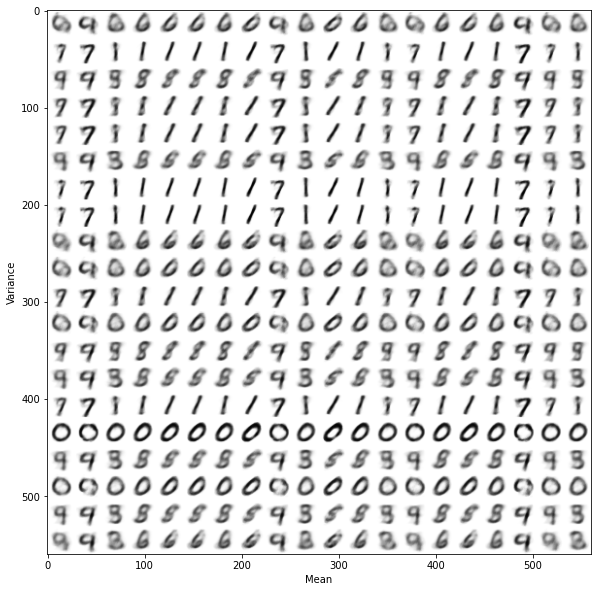

In [657]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.random.uniform(-3, 3, 20)
grid_y = np.random.uniform(-3, 3, 20)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        xd = decoder.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

## Pair 2:

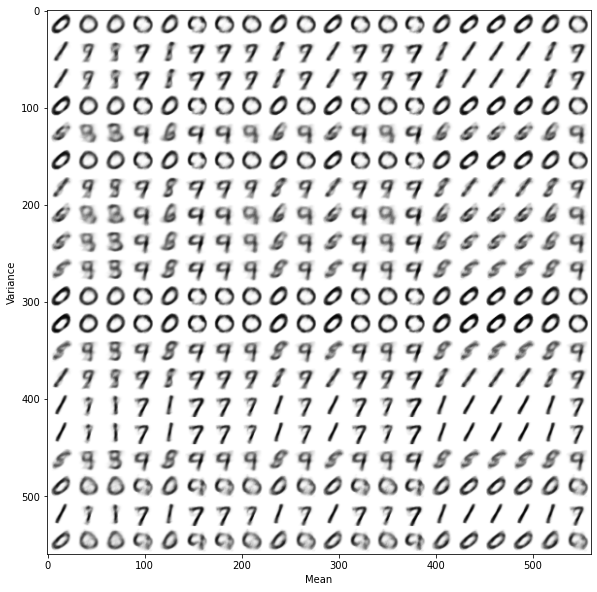

In [658]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.random.uniform(-3, 3, 20)
grid_y = np.random.uniform(-3, 3, 20)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        xd = decoder.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

## Pair 3:

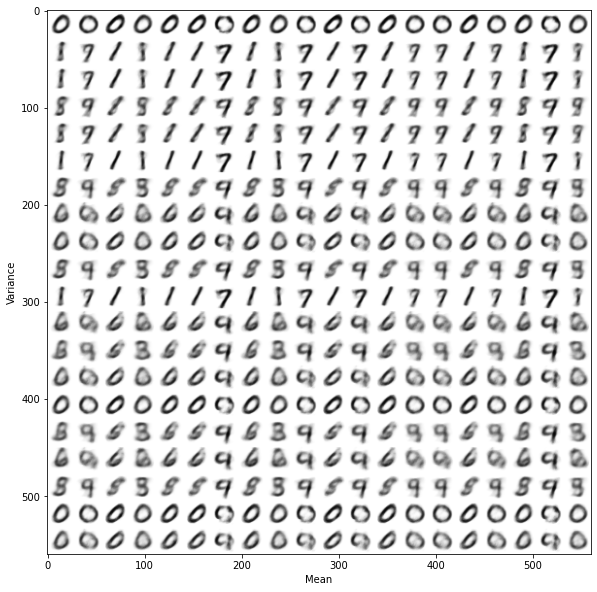

In [659]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.random.uniform(-3, 3, 20)
grid_y = np.random.uniform(-3, 3, 20)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        xd = decoder.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

# 3) Task-3

## Implement VAE to generate MNIST images, where you use convolutional neural network from encoder and deconvolutional neural network for decoder. This one should be super easy for you to catch up with the total score because there are many tutorials on the Internet and you have already solved task-2.

In [737]:
# Train test split

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(train_data)):
    x_train.append(train_data[i][1:])
    y_train.append(train_data[i][:1])
for i in range(len(test_data)):
    x_test.append(test_data[i][1:])
    y_test.append(test_data[i][:1])
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [738]:
# Implementing 0-1 Scaler

for i in range(len(x_train)):
    x_train[i] = (x_train[i] -  np.min(x_train[i], 0)) / (np.max(x_train[i], 0) - np.min(x_train[i], 0)) + 0.0001

for i in range(len(x_test)):
    x_test[i] = (x_test[i] -  np.min(x_test[i], 0)) / (np.max(x_test[i], 0) - np.min(x_test[i], 0)) + 0.0001

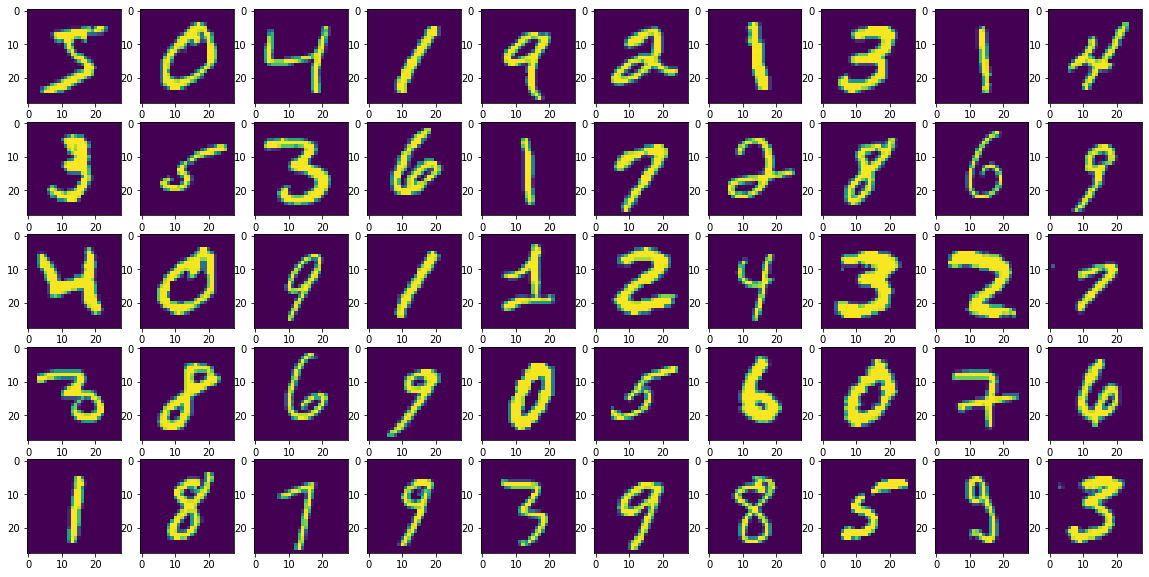

In [739]:
plt.figure(figsize=(20,10))
for i in range(0, len(x_train[:50])):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train[i].reshape((28, 28)))
plt.show()

In [788]:
encoder_inputs = Input(shape = (28, 28, 1))
encoder = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(encoder_inputs)
encoder = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(encoder)
encoder = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(encoder)
init_shape = K.int_shape(encoder)
encoder = Flatten()(encoder)
encoder = Dense(32, activation = 'relu')(encoder)

In [789]:
mean = Dense(2)(encoder)
log_variance = Dense(2)(encoder)
z = Lambda(GaussianSampling, output_shape = (2,))([mean, log_variance])

In [790]:
decoder_inputs = Input(K.int_shape(z)[1:]) 
decoder = Dense(np.prod(init_shape[1:]), activation = 'relu')(decoder_inputs)
decoder = Reshape(init_shape[1:])(decoder)
decoder = Conv2DTranspose(32, (3, 3), padding = 'same', activation = 'relu',strides = (2, 2))(decoder)
decoder = Conv2D(1, (3, 3), padding = 'same', activation = 'sigmoid')(decoder)

In [791]:
encoder_model = Model(encoder_inputs, [mean, log_variance, z])
decoder_model = Model(decoder_inputs, decoder)
z_decoded = decoder_model(z)
encoder_model.summary()
decoder_model.summary()

Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 28, 28, 32)   320         input_48[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 14, 14, 128)  73856       conv2d_45[0][0]                  
___________________________________________________________________________________________

In [792]:
class CustomLoss(Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        reconstruction_loss = binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + log_variance - K.square(mean) - K.exp(log_variance), axis = -1)
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs = inputs)
        return x

In [793]:
x_train = np.reshape(x_train,[-1, 28, 28, 1])
x_test = np.reshape(x_test,[-1, 28, 28, 1])

In [794]:
loss = CustomLoss()([encoder_inputs, z_decoded])
vae = Model(encoder_inputs, loss)
vae.compile(optimizer = 'adam', loss = None, experimental_run_tf_function = False)
vae.summary()

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 28, 28, 32)   320         input_48[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 14, 14, 128)  73856       conv2d_45[0][0]                  
___________________________________________________________________________________________

In [795]:
vae.fit(x = x_train, y = None, shuffle = True, epochs = 10, batch_size = 128, validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 337s 6ms/sample - loss: 0.2507 - val_loss: 0.2133
Epoch 2/10
60000/60000 [==============================] - 345s 6ms/sample - loss: 0.2067 - val_loss: 0.2015
Epoch 3/10
60000/60000 [==============================] - 347s 6ms/sample - loss: 0.1990 - val_loss: 0.1963
Epoch 4/10
60000/60000 [==============================] - 350s 6ms/sample - loss: 0.1950 - val_loss: 0.1932
Epoch 5/10
60000/60000 [==============================] - 353s 6ms/sample - loss: 0.1923 - val_loss: 0.1909
Epoch 6/10
60000/60000 [==============================] - 370s 6ms/sample - loss: 0.1904 - val_loss: 0.1897
Epoch 7/10
60000/60000 [==============================] - 370s 6ms/sample - loss: 0.1888 - val_loss: 0.1881
Epoch 8/10
60000/60000 [==============================] - 367s 6ms/sample - loss: 0.1876 - val_loss: 0.1884
Epoch 9/10
60000/60000 [==============================] - 372s 6ms/sample - loss: 0.18

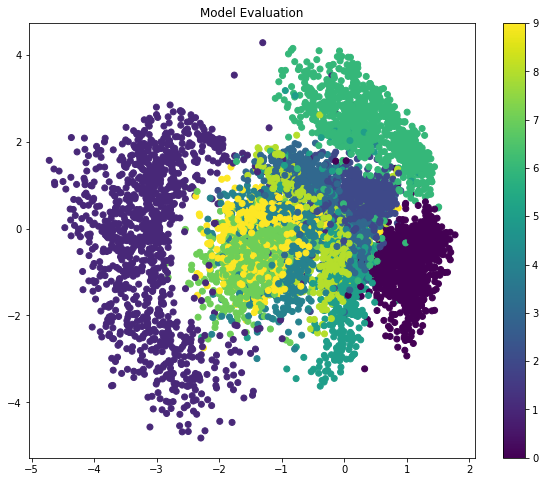

In [797]:
mean, _, _ = encoder_model.predict(x_test, batch_size = 128)
plt.figure(figsize=(10, 8))
plt.scatter(mean[:, 0], mean[:, 1], c = y_test)
plt.colorbar()
plt.title("Model Evaluation")
plt.show()

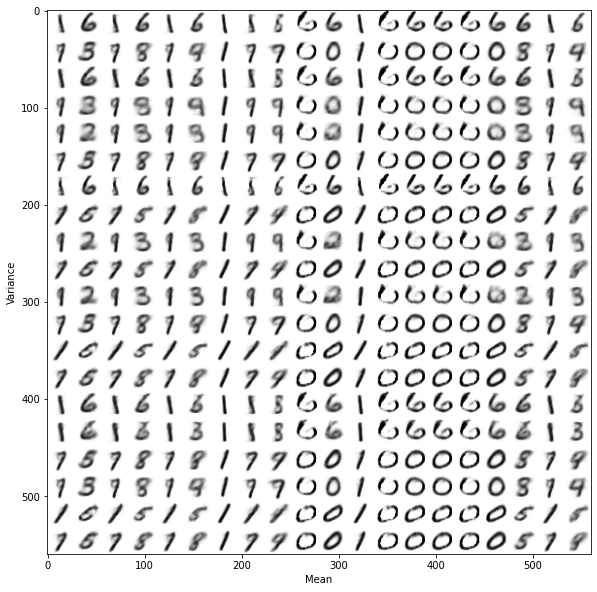

In [800]:
n = 20
digit_size = 28
figure = np.zeros((560, 560))
grid_x = np.random.uniform(-3, 3, 20)
grid_y = np.random.uniform(-3, 3, 20)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        xd = decoder_model.predict(z)
        digit = xd[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.imshow(figure, cmap = 'gray_r')

# 4) Task-4

## Derive and explain the GAN algorithm. Implement GAN and train it from MNIST training data set to generate digits. Show images generated from GAN.

In [706]:
from tqdm import tqdm
import time
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy

In [667]:
train_data = np.loadtxt("Dataset/mnist_train.csv", delimiter=",")
test_data = np.loadtxt("Dataset/mnist_test.csv", delimiter=",")

In [668]:
# Train test split

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(train_data)):
    x_train.append(train_data[i][1:])
    y_train.append(train_data[i][:1])
for i in range(len(test_data)):
    x_test.append(test_data[i][1:])
    y_test.append(test_data[i][:1])
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [669]:
# Implementing 0-1 Scaler

for i in range(len(x_train)):
    x_train[i] = (x_train[i] -  np.min(x_train[i], 0)) / (np.max(x_train[i], 0) - np.min(x_train[i], 0)) + 0.0001

for i in range(len(x_test)):
    x_test[i] = (x_test[i] -  np.min(x_test[i], 0)) / (np.max(x_test[i], 0) - np.min(x_test[i], 0)) + 0.0001

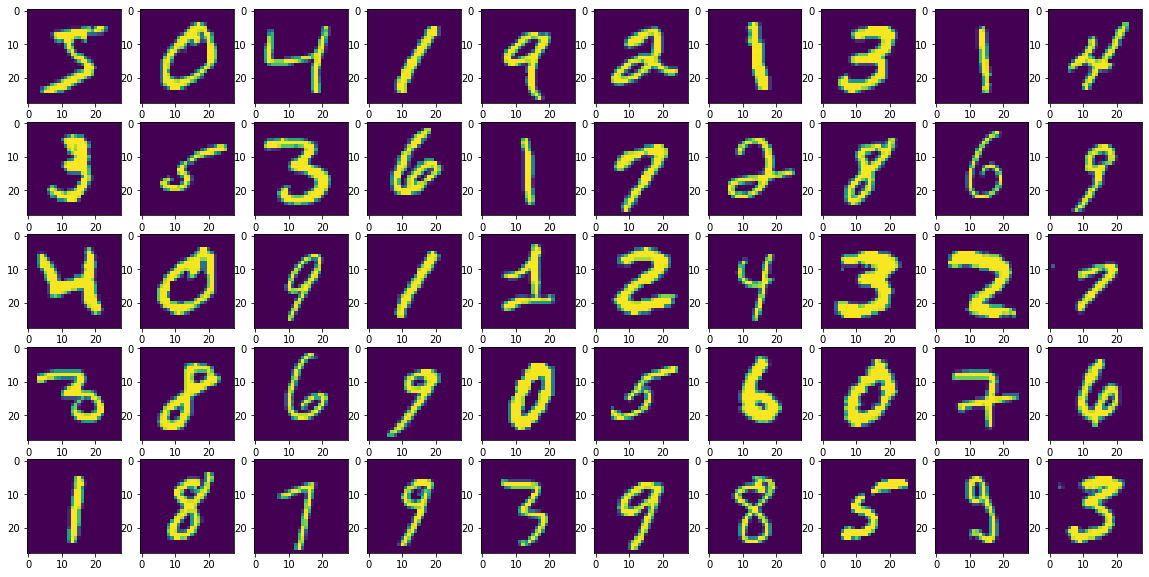

In [670]:
plt.figure(figsize=(20,10))
for i in range(0, len(x_train[:50])):
    plt.subplot(5,10,i+1)
    plt.imshow(x_train[i].reshape((28, 28)))
plt.show()

In [671]:
# Generator
generator = Sequential()

generator.add(Dense(128 * 7 * 7, activation="relu", input_dim = 100))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size = 3, padding = "same"))
generator.add(BatchNormalization(momentum = 0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 3, padding = "same"))
generator.add(BatchNormalization(momentum = 0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(1, kernel_size = 3, padding = "same"))
generator.add(Activation("tanh"))
generator.summary()

input_layer = Input(shape = (100,))
img = generator(input_layer)
gen_model = Model(input_layer, img)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 128)      

In [672]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = (28, 28, 1), padding = "same"))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size = 3, strides = 2, padding = "same"))
discriminator.add(ZeroPadding2D(padding = ((0,1), (0,1))))
discriminator.add(BatchNormalization(momentum = 0.8))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size = 3, strides = 2, padding = "same"))
discriminator.add(BatchNormalization(momentum = 0.8))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size = 3, strides = 1, padding = "same"))
discriminator.add(BatchNormalization(momentum = 0.8))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))
discriminator.summary()
img = Input(shape = (28, 28, 1))
validity = discriminator(img)

disc_model = Model(img, validity)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)         

In [673]:
disc_model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.00002, beta_1 = 0.5), metrics = ['accuracy'])
disc_model.trainable = False
input_layer = Input((100,))
img = gen_model(input_layer)
gan_out = disc_model(img)
gan = Model(input_layer, gan_out)
gan.summary()
gan.compile(loss='binary_crossentropy', optimizer = Adam(lr = 0.0002, beta_1 = 0.5))

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_34 (Model)             (None, 28, 28, 1)         856193    
_________________________________________________________________
model_35 (Model)             (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


In [688]:
disc_losses = [] 
gen_losses = []
total_disc_loss = 0
total_gen_loss = 0
epochs = 100
real_labels = np.ones((128, 1))
fake_labels = np.zeros((128, 1))

for epoch in tqdm(range(epochs)):
    epoch += 1
    start = time.time()
       
    idx = np.random.randint(0, x_train.shape[0], 128)
    imgs = x_train[idx].reshape((128, 28, 28, 1))
    
    noise = np.random.normal(0, 1, (128, 100))
    generated_images = gen_model.predict(noise)

    d_loss_real = disc_model.train_on_batch(imgs, real_labels)
    d_loss_fake = disc_model.train_on_batch(generated_images, fake_labels)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    disc_model.trainable = False
    total_disc_loss += d_loss
    disc_losses.append(d_loss[0])
    g_loss = gan.train_on_batch(noise, real_labels)
    total_gen_loss += g_loss
    gen_losses.append(g_loss)

100%|██████████| 100/100 [08:24<00:00,  5.05s/it]


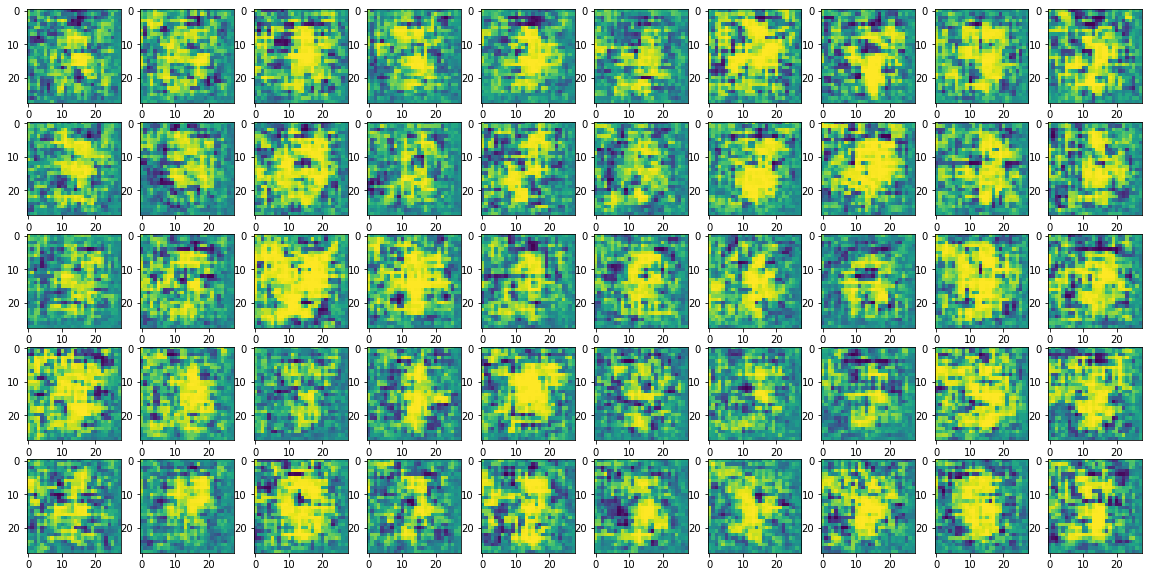

In [689]:
samples = gen_model.predict(noise)
sample_images = [((x + 1.0) * 127.5).astype(np.uint8) for x in samples]
plt.figure(figsize = (20,10)) 
for i in range(0, len(sample_images[:50])):
    plt.subplot(5, 10, i + 1)
    plt.imshow(sample_images[i]) 
plt.show() 

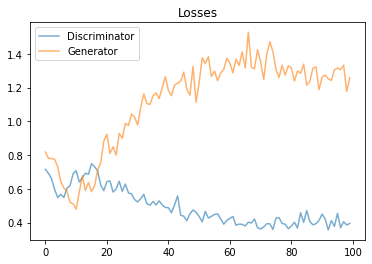

In [690]:
fig, ax = plt.subplots()
plt.plot(disc_losses, label = 'Discriminator', alpha = 0.6)
plt.plot(gen_losses, label = 'Generator', alpha = 0.6)
plt.title("Losses")
plt.legend()
plt.show()

# References:
### RBM: https://www.sciencedirect.com/topics/computer-science/boltzmann-machine
### RBM: http://lyy1994.github.io/machine-learning/2017/04/17/RBM-tensorflow-implementation.html
### RBM: https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/
### VAE: https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
### GAN: https://www.datacamp.com/community/tutorials/generative-adversarial-networks
### GAN: Assignment 5 and Final Project - CSE 595 Fundamentals of Artificial Intelligence